Hello everyone! :)

For this project, I'll be using the following dataset:
- https://www.kaggle.com/shivan118/big-mart-sales-prediction-datasets

This dataset contains a number of features about products sold in a supermarket chain, including the number of items sold for each product at different stores. You can find a detailed description of what each column means at the link above. My goal will be to predict the number of items sold for new products at these stores.

In [281]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mutual_info_score, roc_auc_score, r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [237]:
data = pd.read_csv("data/bigmart_Train-Set.csv")
data.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data prep

In [238]:
data.columns

Index(['ProductID', 'Weight', 'FatContent', 'ProductVisibility', 'ProductType',
       'MRP', 'OutletID', 'EstablishmentYear', 'OutletSize', 'LocationType',
       'OutletType', 'OutletSales'],
      dtype='object')

In [274]:
cols_categorical = ["FatContent", 
                    "ProductType", 
                    "OutletID", 
                    "EstablishmentYear", 
                    "OutletSize", 
                    "LocationType", 
                    "OutletType"]
cols_numerical = ["Weight", 
                  "ProductVisibility", 
                  "MRP"]
cols_to_drop = ["ProductID"]

Let's start by taking a look at the numerical variables (this includes our target variable, `OutletSales`:

In [372]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Weight,8523.0,12.857645,4.226124,4.555,9.310000,12.857645,16.000000,21.350000
ProductVisibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
EstablishmentYear,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
OutletSales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


And now the categorical variables:

In [240]:
data[cols_categorical].nunique()

FatContent            5
ProductType          16
OutletID             10
EstablishmentYear     9
OutletSize            3
LocationType          3
OutletType            4
dtype: int64

In [241]:
for col in cols_categorical:
    print(data[col].value_counts())
    print("_________")

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: FatContent, dtype: int64
_________
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: ProductType, dtype: int64
_________
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: OutletID, dtype: int64
_________
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: EstablishmentYear, dtype: int64
_________
Medium    279

The FatContent column has 5 different values but they all mean the same two things: low_fat or regular. I'll clean that up:

In [242]:
data["FatContent"] = np.where(data["FatContent"].isin(["Regular", "reg"]), "regular", "low_fat")

In [243]:
data["FatContent"].value_counts()

low_fat    5517
regular    3006
Name: FatContent, dtype: int64

Now let's look at missing values:

In [244]:
data.isna().sum()

ProductID               0
Weight               1463
FatContent              0
ProductVisibility       0
ProductType             0
MRP                     0
OutletID                0
EstablishmentYear       0
OutletSize           2410
LocationType            0
OutletType              0
OutletSales             0
dtype: int64

In [245]:
data.loc[data["OutletSize"].isna(), "OutletID"].value_counts()

OUT045    929
OUT017    926
OUT010    555
Name: OutletID, dtype: int64

In [246]:
data.loc[data["OutletID"]=="OUT045", "OutletSize"].value_counts()

Series([], Name: OutletSize, dtype: int64)

In [247]:
data.loc[data["OutletID"]=="OUT017", "OutletSize"].value_counts()

Series([], Name: OutletSize, dtype: int64)

In [248]:
data.loc[data["OutletID"]=="OUT010", "OutletSize"].value_counts()

Series([], Name: OutletSize, dtype: int64)

For these three outlets, information on OutletSize is completely missing. Let's see if we can infer anything about size from OutletType:

In [249]:
data.loc[data["OutletSize"].isna(), ["OutletID", "OutletType"]].drop_duplicates()

,OutletID,OutletType
3,OUT010,Grocery Store
8,OUT045,Supermarket Type1
9,OUT017,Supermarket Type1


In [250]:
data.groupby("OutletType").agg({"OutletSize":"unique", "OutletID":"nunique"})

,OutletSize,OutletID
OutletType,,
Grocery Store,"[nan, Small]",2
Supermarket Type1,"[Medium, High, nan, Small]",6
Supermarket Type2,[Medium],1
Supermarket Type3,[Medium],1


In [251]:
data.loc[data["OutletType"]=="Supermarket Type1", "OutletSize"].drop_duplicates()

0     Medium
4       High
8        NaN
11     Small
Name: OutletSize, dtype: object

I guess we can assume that the outlets of type "Grocery Store" will be small. As for the two remaining Type1 outlets, we can either drop them from out dataset, which would suck... Or we can replace the nan values with the middle value ("Medium"). This is a gross assumption, but in the absence of more information I'll proceed with this:

In [252]:
data["OutletSize"] = np.where(data["OutletType"]=="Grocery Store", "Small", data["OutletSize"])
data["OutletSize"] = data["OutletSize"].fillna("Medium")

As for the variable "Weight", in the absence of more info I'll replace NaNs with the mean value:

In [253]:
data["Weight"] = data["Weight"].fillna(data["Weight"].mean())

In [254]:
data.isna().sum()

ProductID            0
Weight               0
FatContent           0
ProductVisibility    0
ProductType          0
MRP                  0
OutletID             0
EstablishmentYear    0
OutletSize           0
LocationType         0
OutletType           0
OutletSales          0
dtype: int64

No more missing values, yay! :D
Finally, let's take a look at the target variable:

<AxesSubplot:xlabel='OutletSales', ylabel='Count'>

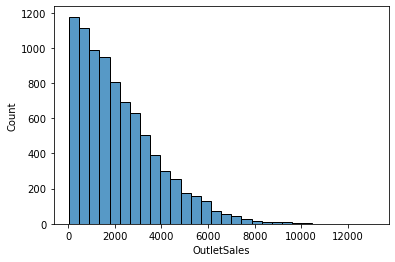

In [255]:
sns.histplot(data["OutletSales"], bins=30)

Since the distribution of the target variable is a long-tailed one, we should logarithmize it before training any models.

<AxesSubplot:xlabel='OutletSales', ylabel='Count'>

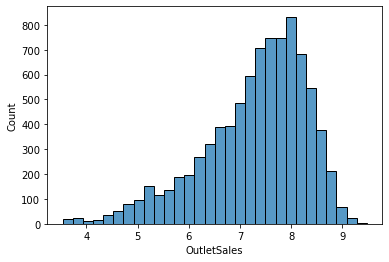

In [256]:
sns.histplot(np.log1p(data["OutletSales"]), bins=30)

# Feature importance

In [257]:
for col in cols_categorical:
    print(col, round(mutual_info_score(data[col], pd.qcut(data["OutletSales"], 5, labels=False)), 3))

FatContent 0.0
ProductType 0.006
OutletID 0.216
EstablishmentYear 0.127
OutletSize 0.056
LocationType 0.02
OutletType 0.214


In [258]:
for col in cols_numerical:
    print(col, round(data[col].corr(data["OutletSales"]), 3))

Weight 0.012
ProductVisibility -0.129
MRP 0.568


The most important categorical features are OutletID/OutletType and EstablishmentYear. FatContent seems to have pretty much no predictive power on sales. Of the numerical variables, the most important one is clearly MRP (price), followed by ProductVisibility. 

Interestingly, ProductVisibility correlates _negatively_ with Sales - not what I would have expected. Maybe BigMart tries to increase sales of low-performing products by assigning them more shelf space? If so, that strategy doesn't seem to pay off.

# Model selection

I'll start by creating the feature matrices and target variable arrays (logarithmized).

In [275]:
full_train, test = train_test_split(data[cols_categorical + cols_numerical + ["OutletSales"]], 
                                    test_size=0.2, 
                                    random_state=17)

y_full_train = np.log1p(full_train["OutletSales"])
y_test = np.log1p(test["OutletSales"])

del full_train["OutletSales"]
del test["OutletSales"]

dict_full_train = full_train.to_dict(orient="records")
dict_test = test.to_dict(orient="records")

dv=DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_test = dv.transform(dict_test)

For selecting the best model and tuning its parameters, I will use 5-fold cross-validation. For this purpose, I'll be using the `cross_validate()` function instead of the `KFold` class that we used in the course lectures/homework. It lives in sklearn.model_selection package. Instead of returning the indices to use for subsetting the dataframe containing the data, it takes the full dataframe directly, as well as an instantiated model object and one or more scoring methods (for instance, the mean squared error) and returns an array containing, among other things, the calculated mean squared error for the model trained on each fold. For more info on this function, check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).

In [160]:
def score_model(model, X, y):
    results = cross_validate(model, X, y, scoring=["neg_mean_squared_error", "r2"])
    print(f"MSE: {round(results['test_neg_mean_squared_error'].mean(), 3)}+-{round(results['test_neg_mean_squared_error'].std(), 3)}")
    print(f"r2: {round(results['test_r2'].mean(), 4)}+-{round(results['test_r2'].std(), 4)}")

In [95]:
model = LinearRegression()
score_model(model, X_full_train, y_full_train)

MSE: -0.291+-0.009
r2: 0.719+-0.02


In [99]:
for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = Ridge(alpha=alpha)
    print("Alpha =", alpha)
    score_model(model, X_full_train, y_full_train)
    print("______")

Alpha = 0.001
MSE: -0.291+-0.009
r2: 0.719+-0.02
______
Alpha = 0.01
MSE: -0.291+-0.009
r2: 0.719+-0.02
______
Alpha = 0.1
MSE: -0.291+-0.008
r2: 0.719+-0.02
______
Alpha = 1
MSE: -0.291+-0.008
r2: 0.719+-0.02
______
Alpha = 10
MSE: -0.291+-0.008
r2: 0.719+-0.02
______
Alpha = 100
MSE: -0.293+-0.007
r2: 0.717+-0.019
______


Ridge regression doesn't seem to do any better than Linear regression - regularization doesn't help with this dataset.

Let's try a decision tree regressor:

In [100]:
model = DecisionTreeRegressor()
score_model(model, X_full_train, y_full_train)

MSE: -0.563+-0.013
r2: 0.456+-0.027


With default parameters, a Decision Tree isn't performing very impressively. Let's see if we can boost performance by tuning the hyperparameters.


Tree-based models have more hyperparameters than the linear models I tried before, so in order to tune those parameters I will use GridSearchCV. This function lives in the sklearn.model_selection package. It takes as input among other things an instantiated model and a dictionary with parameters and the values we want to try out, and then fits the model for each combination of those parameters. Compared to how we did it in the classes, it has the advantage that it tries all possible combinations of the parameter values we give it, instead of finding the best value for one parameter holding everything else constant, then proceeding to the next parameter. For more info, check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [153]:
param_grid = {
    "max_depth": [1,2,3,4,5,6,7,8,9,10,15,20],
    "min_samples_leaf": [1, 2, 3, 5, 10, 20],
    "criterion": ["mse", "friedman_mse", "mae", "poisson"]
}

grid = GridSearchCV(DecisionTreeRegressor(random_state=17), 
                    param_grid, 
                    scoring = "r2", 
                    refit = True, 
                    verbose = 1,
                    n_jobs=-1)

In [154]:
grid.fit(X_full_train, y_full_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(estimator=DecisionTreeRegressor(random_state=17), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 3, 5, 10, 20]},
             scoring='r2', verbose=1)

In [155]:
grid.best_params_

{'criterion': 'mse', 'max_depth': 6, 'min_samples_leaf': 20}

In [156]:
grid.best_score_

0.7297120094800071

That's slightly better (by 1%) compared to the linear model we tried first. If we were worrying about speed, this marginal increase probably wouldn't justify using Trees; but that's not the case here, since the Decision Tree model still runs fast.

Let's try a Random Forest Regressor now:

In [165]:
param_grid = {
    "max_depth": [1,4,5,6,7,8,10,15,20],
    "min_samples_leaf": [1, 2, 5, 10, 20, 30],
    "n_estimators": [5, 10, 25, 50]
}

grid = GridSearchCV(RandomForestRegressor(random_state=17), 
                    param_grid, 
                    scoring = "r2", 
                    refit = True, 
                    verbose = 1,
                    n_jobs=-1)

In [166]:
grid.fit(X_full_train, y_full_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [1, 4, 5, 6, 7, 8, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 5, 10, 20, 30],
                         'n_estimators': [5, 10, 25, 50]},
             scoring='r2', verbose=1)

In [167]:
grid.best_params_

{'max_depth': 6, 'min_samples_leaf': 30, 'n_estimators': 50}

In [168]:
grid.best_score_

0.7382646036352969

Another slight improvement! Finally, let's try XGBoost. I'll use the XGBRegressor estimator instead of DMatrices and the train function from XGBoost. It does the same but uses a similar syntax as the rest of the sklearn models, so I find it more convenient. More about it in the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbregressor#xgboost.XGBRegressor).

In [192]:
param_grid = {
    "eta": [0.1, 0.2, 0.3],
    "colsample_bytree": [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.9], 
    "min_child_weight": [10, 20, 30]
}

model = XGBRegressor(max_depth=6, n_estimators=50, n_jobs=-1)

grid = GridSearchCV(model, 
                    param_grid, 
                    scoring = "r2", 
                    refit = True, 
                    verbose = 1,
                    n_jobs=-1)

grid.fit(X_full_train, y_full_train)

grid.best_params_

Fitting 5 folds for each of 63 candidates, totalling 315 fits


{'colsample_bytree': 0.55, 'eta': 0.1, 'min_child_weight': 20}

In [193]:
grid.best_score_

0.7364842074819923

XGBoost didn't improve on the performance achieved by the random forest. So I'll stick with the random forest! Let's train the final model:

In [276]:
model = RandomForestRegressor(max_depth=6, 
                              min_samples_leaf=30, 
                              n_estimators=50,
                              random_state=17)

model.fit(X_full_train, y_full_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_pred, y_test))
print("r2:", r2_score(y_pred, y_test))

MSE: 0.27337637371229423
r2: 0.6064384828515718


It's clear that the model is overfitting, judging from the drop in performance from the training dataset to the test dataset. Let's see if linear regression overfits less (since it's a simpler model):

In [277]:
model = LinearRegression()

model.fit(X_full_train, y_full_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_pred, y_test))
print("r2:", r2_score(y_pred, y_test))

MSE: 0.2837043994160826
r2: 0.5890846626553069


Nope. It's even worse. God help me.

One possibility would be to reduce the number of features. In fact, several of the features that we've been using are not very important, according to the correlation coefficients/mutual info scores I calculated above. Others are highly correlated (all the features related to the outlets can probably be dropped in favor of OutletID. Let's see how this affects performance with both models:

In [295]:
cols_categorical = ["ProductType", 
                    "OutletID"]
cols_numerical = ["ProductVisibility", 
                  "MRP"]

full_train, test = train_test_split(data[cols_categorical + cols_numerical + ["OutletSales"]], 
                                    test_size=0.2, 
                                    random_state=17)

y_full_train = np.log1p(full_train["OutletSales"])
y_test = np.log1p(test["OutletSales"])

del full_train["OutletSales"]
del test["OutletSales"]

dict_full_train = full_train.to_dict(orient="records")
dict_test = test.to_dict(orient="records")

dv=DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_test = dv.transform(dict_test)

model = RandomForestRegressor(max_depth=6, 
                              min_samples_leaf=30, 
                              n_estimators=50,
                              random_state=17)

model.fit(X_full_train, y_full_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_pred, y_test))
print("r2:", r2_score(y_pred, y_test))

MSE: 0.27275492760519043
r2: 0.6064072957354121


In [279]:
model = LinearRegression()

model.fit(X_full_train, y_full_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_pred, y_test))
print("r2:", r2_score(y_pred, y_test))

MSE: 0.28369056416811433
r2: 0.5890843660249417


The features we removed were pretty useless indeed (MSE and R2 barely changed at all), but the model is still overfitting. This sucks, but for the purposes of the midterm project, I'll accept it. The biggest lesson I've learned from this project: in order to make good predictions, you need to have good features.

The final model I will use for deployment as a web service will be the Random Forest with reduced features and the following parameters:

- max_depth=6, 
- min_samples_leaf=30, 
- n_estimators=50,
- random_state=17

The model was deployed on Heroku as a web service. Check the readme file in the repository root for more details on how it was deployed and how to submit a request for predicting sales numbers for a new product! :)